# Tamil Nadu SIR 2026 Draft Voter Roll Impact Analysis

Link for the Report https://github.com/ijaihari/Tamil-Nadu-SIR-2026-Draft-Voter-Roll-Impact-Analysis/blob/main/Readme.md

### Objective

The goal is to evaluate whether **voter roll revisions under Tamil Nadu SIR (2026)** are large enough to **numerically affect election outcomes**, using **victory margin** from the 2021 Assembly Election as the sensitivity threshold.

This is a **data-driven impact analysis**, not an allegation-based study.


### Tamil Nadu Total Voters Count

SIR - Special Intensive Revision <br/>
SSR - Special Summary Revision

### Key State-Level Numbers

| Metric | Count |
|------|------|
| Total voters (2021 Assembly Roll) | **6.29 crore** |
| Total voters (SSR 2025 – pre-SIR) | **6.36 crore** |
| Total voters (Draft Roll after SIR 2026) | **5.43 crore** |
| **Net voters removed (SIR 2026)** | **~ 97 lakh** |

### One-Line Takeaway

Tamil Nadu’s draft electoral roll shows a net reduction of ~ 97 lakh voters after SIR 2026.


Sources

https://en.wikipedia.org/wiki/2021_Tamil_Nadu_Legislative_Assembly_election <br/>
https://www.elections.tn.gov.in/ACwise_Gendercount_06012025.aspx  <br/>
https://www.elections.tn.gov.in/ACwise_Gendercount_19122025.aspx

## Analytical Framework

This analysis is based on three simple ideas:

1. **Victory Margin (2021)**  
   - The number of votes that decided the election result.

2. **Not Voted (2021)**  
   - Registered voters who did not vote, used as a baseline for comparison.

3. **Removed Voters (2026)**  
   - Changes in the voter roll after the SIR revision.
### Core Question
> Are voter roll changes large enough to be considered significant when compared to the margin that decided the election?


In [1]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("../db/tn_election.db")

## Load Curated Tables

The following pre-processed tables are loaded from SQLite:

- `election_results_2021` → victory margin & parties  
- `voters_2021` → turnout & not voted baseline  
- `voters_2026` → revised voter roll (SIR 2026)


In [2]:
df_results_2021 = pd.read_sql("SELECT * FROM election_results_2021", conn)

df_voters_2021 = pd.read_sql("SELECT * FROM voters_2021", conn)

df_voters_2026 = pd.read_sql("SELECT * FROM voters_2026", conn)

## Compare Voter Rolls (2021 vs 2026)


In [3]:
df_roll_compare = (
    df_voters_2021
    .merge(
        df_voters_2026,
        on=["ac_no", "ac_name"],
        how="inner"
    )
)

df_roll_compare["removed_voters_2026"] = (
    df_roll_compare["total_eligible_voters_2021"]
    - df_roll_compare["total_eligible_voters_2026"]
)

df_roll_compare.head()

,ac_no,ac_name,total_votes_polled_2021,total_eligible_voters_2021,not_voted_2021,total_eligible_voters_2026,removed_voters_2026
0,1,Gummidipoondi,222069,281688,59619,242558,39130
1,2,Ponneri,210354,267368,57014,239141,28227
2,3,Tiruttani,232624,291336,58712,252154,39182
3,4,Thiruvallur,214243,274982,60739,238818,36164
4,5,Poonamallee,263736,358218,94482,348034,10184


## Attach Election Outcome Data

Victory margin from the 2021 election is now joined with
voter roll changes to assess **outcome sensitivity**.

In [4]:
df_analysis = (
    df_results_2021
    .merge(
        df_roll_compare,
        on=["ac_no", "ac_name"],
        how="inner"
    )
)

df_analysis.head()

,ac_no,ac_name,winner_party,votes_winner,runnerup_party,votes_runnerup,victory_margin,total_votes_polled_2021,total_eligible_voters_2021,not_voted_2021,total_eligible_voters_2026,removed_voters_2026
0,1,Gummidipoondi,DMK,126452,PMK,75514,50938,222069,281688,59619,242558,39130
1,2,Ponneri,INC,94528,ADMK,84839,9689,210354,267368,57014,239141,28227
2,3,Tiruttani,DMK,120314,ADMK,91061,29253,232624,291336,58712,252154,39182
3,4,Thiruvallur,DMK,107709,ADMK,85008,22701,214243,274982,60739,238818,36164
4,5,Poonamallee,DMK,149578,PMK,55468,94110,263736,358218,94482,348034,10184


## Core Impact Tests

Two key comparisons are performed:

1. **Removed Voters vs Victory Margin**
   - Determines if roll changes exceed the threshold that decided the election.

2. **Removed Voters vs Not Voted (2021)**
   - Provides historical inactivity context.

In [5]:
df_analysis["removed_gt_margin"] = (
    df_analysis["removed_voters_2026"] > df_analysis["victory_margin"]
)

df_analysis["removed_gt_not_voted"] = (
    df_analysis["removed_voters_2026"] > df_analysis["not_voted_2021"]
)

## Risk Classification

Each constituency is classified based on the magnitude of
voter roll change relative to:

- victory margin
- historical non-participation

This creates a **numerical risk categorization**, not a judgement.


### Risk Level Explanation

- **Low Impact**  
  Removed voters are smaller than the victory margin.  
  → Roll changes are unlikely to affect the result.

- **Moderate Impact**  
  Removed voters exceed past non-voters but not the victory margin.  
  → Changes are noticeable but still below the outcome threshold.

- **High Impact**  
  Removed voters are greater than the victory margin.  
  → The constituency becomes sensitive, and the result could potentially change.

- **Critical Impact**  
  Removed voters exceed both the victory margin and historical non-voters.  
  → Highest sensitivity, where roll changes are large enough to matter significantly.

- **No Removal / Increase**  
  Voter count increased or remained stable.  
  → No risk from voter roll changes.


In [6]:
def classify_risk(row):
    if row["removed_voters_2026"] <= 0:
        return "No Removal / Increase"
    if row["removed_gt_margin"] and row["removed_gt_not_voted"]:
        return "Critical Impact"
    if row["removed_gt_margin"]:
        return "High Impact"
    if row["removed_gt_not_voted"]:
        return "Moderate Impact"
    return "Low Impact"

df_analysis["risk_level"] = df_analysis.apply(classify_risk, axis=1)

## Final Analytical Dataset

This table represents the **final output** of the project
and is used for reporting, visualization, and SQL storage.


In [7]:
df_final_analysis = df_analysis[
    [
        "ac_no",
        "ac_name",
        "winner_party",
        "runnerup_party",
        "victory_margin",
        "total_eligible_voters_2021",
        "total_eligible_voters_2026",
        "removed_voters_2026",
        "not_voted_2021",
        "risk_level"
    ]
].sort_values(
    "removed_voters_2026",
    ascending=False
)

df_final_analysis.head()

,ac_no,ac_name,winner_party,runnerup_party,victory_margin,total_eligible_voters_2021,total_eligible_voters_2026,removed_voters_2026,not_voted_2021,risk_level
26,27,Shozhinganallur,DMK,ADMK,35405,698893,484011,214882,310538,High Impact
29,30,Pallavaram,DMK,ADMK,37783,436239,294712,141527,170049,High Impact
6,7,Maduravoyal,DMK,ADMK,31721,452195,325407,126788,178325,High Impact
25,26,Velachery,INC,ADMK,4352,314578,189999,124579,137864,High Impact
20,21,Anna Nagar,DMK,ADMK,27445,286090,162135,123955,120994,Critical Impact


## Key Insights

- Constituencies where **removed voters exceed victory margin**
  are numerically sensitive to roll revisions.

- Comparing removals with **not voted (2021)** prevents misleading conclusions.

- The analysis highlights **outcome sensitivity**, not intent.


In [8]:
df_final_analysis.to_sql(
    "voter_roll_impact_analysis",
    conn,
    if_exists="replace",
    index=False
)

232

## Visual Impact Analysis

In [9]:
import matplotlib.pyplot as plt
import numpy as np

### Victory Margin vs Removed Voters (Core Sensitivity Plot)

This scatter plot visualizes whether voter roll changes
exceed the margin that decided the 2021 election.

- X-axis: Victory Margin (2021)
- Y-axis: Removed Voters (2026)
- Points above the horizontal axis indicate voter removal

Constituencies where removed voters exceed the victory margin
are numerically sensitive to roll revisions.


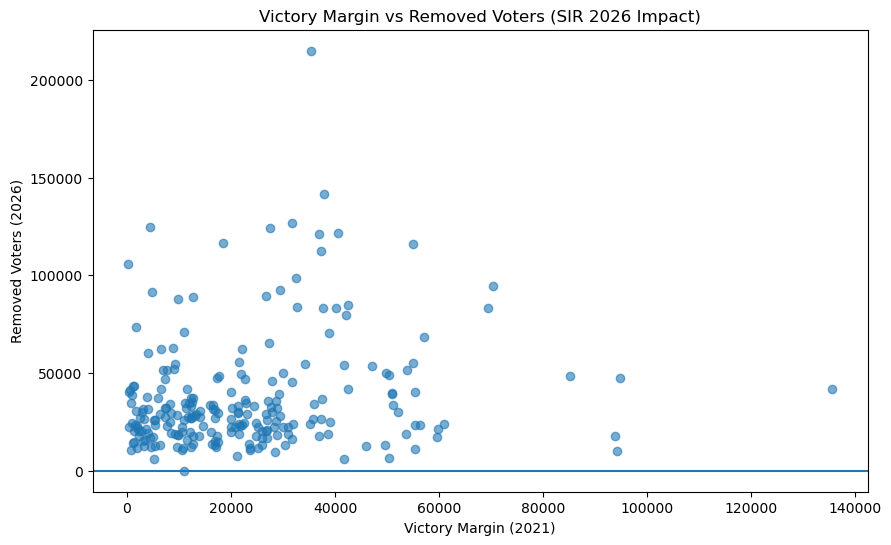

In [10]:
plt.figure(figsize=(10, 6))

plt.scatter(
    df_final_analysis["victory_margin"],
    df_final_analysis["removed_voters_2026"],
    alpha=0.6
)

plt.axhline(y=0)
plt.xlabel("Victory Margin (2021)")
plt.ylabel("Removed Voters (2026)")
plt.title("Victory Margin vs Removed Voters (SIR 2026 Impact)")

plt.show()

### How to read the chart

- Points above the zero line indicate constituencies where voters were removed

- Further right → constituency was won by a larger margin in 2021

- Higher up → larger voter roll reduction in 2026

### Direct Takeaway from the above chart

**Key observation:**  
> In many constituencies, the number of voters removed is higher than the margin that decided the election.

**What this means:**  
> When more voters are removed than the victory margin, the result could potentially change, especially since the total number of voters did not increase significantly from 2021 to 2025 to balance these removals.


### High-Impact Constituencies: Removed Voters vs Victory Margin

This clustered bar chart compares
removed voters and victory margins **side-by-side**
for constituencies classified as high or critical impact.

This visualization clearly shows where voter roll changes
exceed the threshold that decided the election.

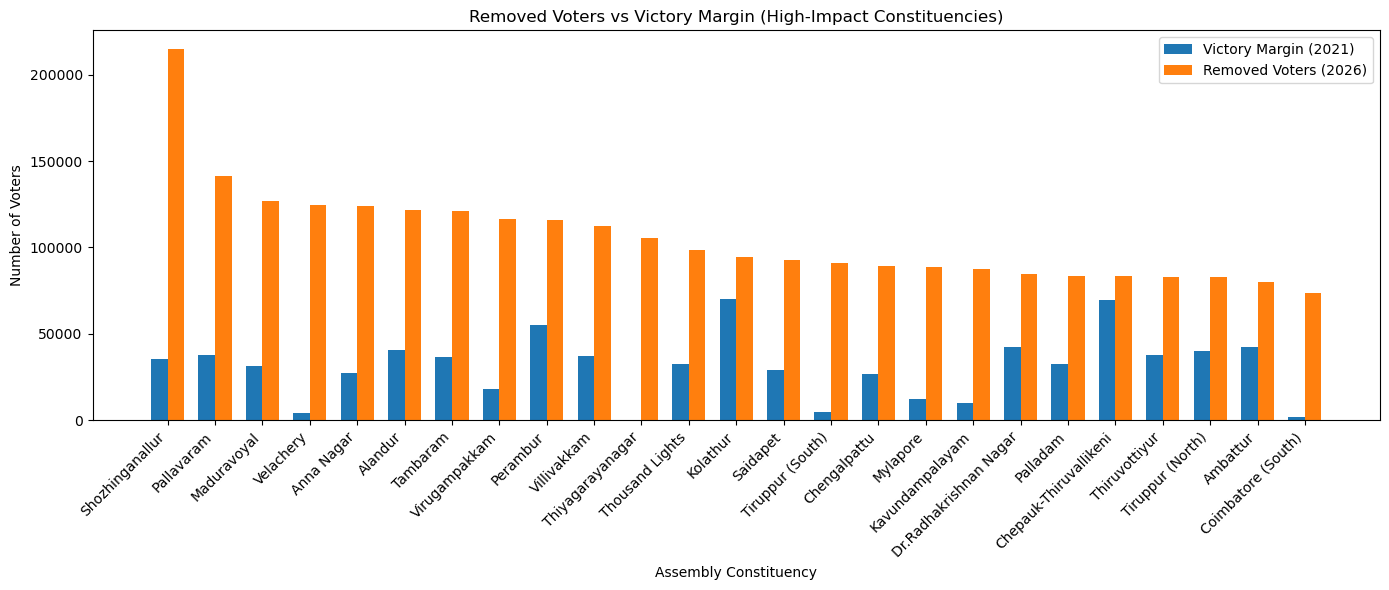

In [11]:
high_impact = df_final_analysis[
    df_final_analysis["risk_level"].isin(
        ["High Impact", "Critical Impact"]
    )
].sort_values(
    "removed_voters_2026",
    ascending=False
).head(25)

x = np.arange(len(high_impact))
width = 0.35

plt.figure(figsize=(14, 6))

plt.bar(
    x - width/2,
    high_impact["victory_margin"],
    width,
    label="Victory Margin (2021)"
)

plt.bar(
    x + width/2,
    high_impact["removed_voters_2026"],
    width,
    label="Removed Voters (2026)"
)

plt.xticks(
    x,
    high_impact["ac_name"],
    rotation=45,
    ha="right"
)

plt.xlabel("Assembly Constituency")
plt.ylabel("Number of Voters")
plt.title("Removed Voters vs Victory Margin (High-Impact Constituencies)")
plt.legend()
plt.tight_layout()
plt.show()


### Direct take away for the above chart

**Key observation:**  
In these high-impact constituencies, the number of voters removed in 2026 is consistently higher than the victory margin from the 2021 election.

**What this means:**  
> When the bar representing removed voters is taller than the victory margin bar, the number of voters removed is large enough to potentially influence the election result, especially since there was no significant increase in voter count between 2021 and 2025 to offset these removals.

**Why this chart matters:**  
> This side-by-side comparison makes it easy to see which constituencies are more sensitive, as the scale of voter roll changes clearly exceeds the margin that decided the election.


In [12]:
total_critical_high_impact = high_impact = df_final_analysis[
    df_final_analysis["risk_level"].isin(
        ["High Impact", "Critical Impact"]
    )
]
total_critical_high_impact.head()

,ac_no,ac_name,winner_party,runnerup_party,victory_margin,total_eligible_voters_2021,total_eligible_voters_2026,removed_voters_2026,not_voted_2021,risk_level
26,27,Shozhinganallur,DMK,ADMK,35405,698893,484011,214882,310538,High Impact
29,30,Pallavaram,DMK,ADMK,37783,436239,294712,141527,170049,High Impact
6,7,Maduravoyal,DMK,ADMK,31721,452195,325407,126788,178325,High Impact
25,26,Velachery,INC,ADMK,4352,314578,189999,124579,137864,High Impact
20,21,Anna Nagar,DMK,ADMK,27445,286090,162135,123955,120994,Critical Impact


### Distribution of Risk Levels

This chart summarizes how many constituencies fall into each
risk category, providing a high-level overview of impact spread
across the state.


### Risk Level Explanation

- **Low Impact**  
  Removed voters are smaller than the victory margin.  
  → Roll changes are unlikely to affect the result.

- **Moderate Impact**  
  Removed voters exceed past non-voters but not the victory margin.  
  → Changes are noticeable but still below the outcome threshold.

- **High Impact**  
  Removed voters are greater than the victory margin.  
  → The constituency becomes sensitive, and the result could potentially change.

- **Critical Impact**  
  Removed voters exceed both the victory margin and historical non-voters.  
  → Highest sensitivity, where roll changes are large enough to matter significantly.

- **No Removal / Increase**  
  Voter count increased or remained stable.  
  → No risk from voter roll changes.


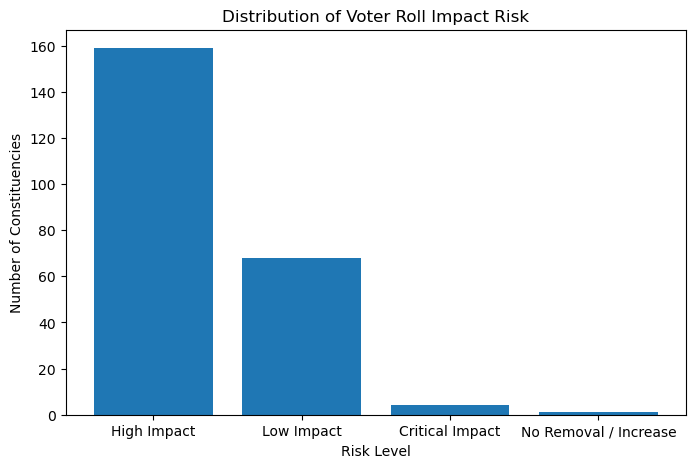

In [13]:
risk_counts = df_final_analysis["risk_level"].value_counts()

plt.figure(figsize=(8, 5))

plt.bar(
    risk_counts.index,
    risk_counts.values
)

plt.xlabel("Risk Level")
plt.ylabel("Number of Constituencies")
plt.title("Distribution of Voter Roll Impact Risk")

plt.show()

### Winning majority context

- To form a government in Tamil Nadu, **118 out of 234 seats** are required.
- When many seats are high impact, even small changes across multiple constituencies can matter at the overall result level.

### Key Findings
- **159 out of 234 constituencies** fall under the **High Impact** category
- The winning side in 2021 secured **133 seats**, with **118 required** to form a government
- A large number of seats are numerically sensitive to voter roll changes

## Logistic Regression: Identifying High-Impact Constituencies

In this section, we use **Logistic Regression** to estimate whether a constituency is **High Impact** based on voter roll changes and election-related factors.

This model does **not predict election results**.  
It classifies constituencies based on whether voter roll changes **exceed the historical victory margin**.


In [14]:
df_ml = df_final_analysis.copy()

df_ml["high_impact_flag"] = (
    df_ml["removed_voters_2026"] > df_ml["victory_margin"]
).astype(int)

df_ml[["ac_no", "high_impact_flag"]].head()


,ac_no,high_impact_flag
26,27,1
29,30,1
6,7,1
25,26,1
20,21,1


**What this does:**  
- Assigns `1` to constituencies where removed voters exceed the victory margin  
- Assigns `0` otherwise  

This directly reflects the analytical rule already used in the project.


In [15]:
df_ml["turnout_rate_2021"] = (
    df_ml["total_eligible_voters_2021"]
    - df_ml["not_voted_2021"]
) / df_ml["total_eligible_voters_2021"]

df_ml["roll_change_pct"] = (
    df_ml["removed_voters_2026"]
    / df_ml["total_eligible_voters_2021"]
)


In [16]:
features = [
    "victory_margin",
    "removed_voters_2026",
    "not_voted_2021",
    "turnout_rate_2021",
    "roll_change_pct"
]

X = df_ml[features]
y = df_ml["high_impact_flag"]


**Features used:**
- Victory margin (how close the election was)
- Removed voters (scale of roll change)
- Not voted (historical inactivity)
- Turnout rate
- Roll change percentage

All features are interpretable and grounded in data.


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


We split the data into training and testing sets to evaluate the model fairly.


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [19]:
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=1000))
])

pipeline


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('log_reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not 

In [20]:
pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('log_reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not 

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = pipeline.predict(X_test)


In [22]:
accuracy = accuracy_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.98      1.00      0.99        41

    accuracy                           0.98        58
   macro avg       0.99      0.97      0.98        58
weighted avg       0.98      0.98      0.98        58



**How to read the results:**
- Accuracy shows overall classification performance
- Confusion matrix shows correct vs incorrect classifications
- Precision & recall indicate how well High Impact seats are identified


In [23]:
df_ml["high_impact_probability"] = pipeline.predict_proba(X)[:, 1]

df_ml[
    [
        "ac_no",
        "ac_name",
        "victory_margin",
        "removed_voters_2026",
        "high_impact_probability"
    ]
].sort_values(
    "high_impact_probability",
    ascending=False
).head(10)


,ac_no,ac_name,victory_margin,removed_voters_2026,high_impact_probability
26,27,Shozhinganallur,35405,214882,1.000000
25,26,Velachery,4352,124579,1.000000
23,24,Thiyagarayanagar,137,105542,1.000000
21,22,Virugampakkam,18367,116568,1.000000
20,21,Anna Nagar,27445,123955,0.999999
111,114,Tiruppur (South),4709,91201,0.999999
29,30,Pallavaram,37783,141527,0.999997
24,25,Mylapore,12633,88976,0.999995
6,7,Maduravoyal,31721,126788,0.999995
13,14,Villivakkam,37237,112622,0.999993


**Why this matters:**
Instead of a hard yes/no label, we now have a **probability score** that shows how strongly a constituency belongs to the High Impact category.


In [24]:
coefficients = pipeline.named_steps["log_reg"].coef_[0]

coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": coefficients
}).sort_values(
    "coefficient",
    ascending=False
)

coef_df


,feature,coefficient
1,removed_voters_2026,1.965732
4,roll_change_pct,1.908149
2,not_voted_2021,0.848723
3,turnout_rate_2021,0.284034
0,victory_margin,-3.511599


### Interpretation of Logistic Regression Coefficients

The table above shows the coefficients from the logistic regression model, which indicate how each feature influences the likelihood of a constituency being classified as **High Impact**.

- **Positive coefficients** increase the likelihood of a constituency being High Impact.
- **Negative coefficients** decrease the likelihood.
- The **larger the absolute value**, the stronger the influence of that feature.

**Key interpretations:**
- **Removed Voters (2026)** has the strongest positive effect, indicating that higher voter removals significantly increase impact sensitivity.
- **Roll Change Percentage** also has a strong positive influence, showing that relative roll reductions matter in addition to absolute numbers.
- **Not Voted (2021)** has a moderate positive effect, providing contextual support but not outweighing large roll changes.
- **Turnout Rate (2021)** has a smaller influence compared to other factors.
- **Victory Margin (2021)** has a strong negative effect, meaning constituencies with larger winning margins are less likely to be High Impact.

**Overall takeaway:**  
Voter roll removals and roll change size are the most influential factors in determining impact sensitivity, while larger victory margins significantly reduce this risk.


In [25]:
final_sensitive_constituencies = df_ml[
    (df_ml["risk_level"] == "High Impact") &
    (df_ml["high_impact_probability"] >= 0.7)
][
    [
        "ac_no",
        "ac_name",
        "victory_margin",
        "removed_voters_2026",
        "high_impact_probability"
    ]
].sort_values(
    "removed_voters_2026",
    ascending=False
)

final_sensitive_constituencies.head()


,ac_no,ac_name,victory_margin,removed_voters_2026,high_impact_probability
26,27,Shozhinganallur,35405,214882,1.000000
29,30,Pallavaram,37783,141527,0.999997
6,7,Maduravoyal,31721,126788,0.999995
25,26,Velachery,4352,124579,1.000000
27,28,Alandur,40571,121847,0.999968


In [26]:
final_sensitive_constituencies.to_csv(
    "../result data/high_impact_constituencies.csv",
    index=False
)

## High Impact Constituencies (Top 50)
- A total of **159 constituencies** are classified as High Impact.  
- The table above shows the **Top 50 by removed voter count**.  
- The complete list is available here: [high_impact_constituencies.csv](result%20data/high_impact_constituencies.csv)


| S.No | AC No | Constituency | Victory Margin (2021) | Removed Voters (2026) | High Impact Probability |
|----:|------:|-------------|----------------------:|----------------------:|------------------------:|
| 1 | 27 | Shozhinganallur | 35,405 | 214,882 | 1.000000 |
| 2 | 30 | Pallavaram | 37,783 | 141,527 | 0.999997 |
| 3 | 7 | Maduravoyal | 31,721 | 126,788 | 0.999995 |
| 4 | 26 | Velachery | 4,352 | 124,579 | 1.000000 |
| 5 | 28 | Alandur | 40,571 | 121,847 | 0.999968 |
| 6 | 31 | Tambaram | 36,824 | 121,308 | 0.999997 |
| 7 | 22 | Virugampakkam | 18,367 | 116,568 | 0.999999 |
| 8 | 12 | Perambur | 54,976 | 115,761 | 0.999997 |
| 9 | 14 | Villivakkam | 37,237 | 112,622 | 0.999993 |
|10 | 24 | Thiyagarayanagar | 137 | 105,542 | 1.000000 |
|11 | 20 | Thousand Lights | 32,462 | 98,703 | 0.999921 |
|12 | 13 | Kolathur | 70,384 | 94,356 | 0.999846 |
|13 | 23 | Saidapet | 29,408 | 92,544 | 0.999932 |
|14 |114 | Tiruppur (South) | 4,709 | 91,201 | 0.999999 |
|15 | 25 | Mylapore | 12,633 | 88,976 | 0.999995 |
|16 | 6 | Ambattur | 16,448 | 87,422 | 0.999901 |
|17 | 46 | Hosur | 26,218 | 83,854 | 0.999782 |
|18 | 10 | Egmore | 53,287 | 82,819 | 0.999642 |
|19 | 83 | Tiruchendur | 13,721 | 79,935 | 0.999391 |
|20 | 58 | Salem North | 11,400 | 77,226 | 0.999323 |
|21 | 59 | Salem South | 20,431 | 76,912 | 0.999252 |
|22 | 95 | Karur | 70,654 | 76,421 | 0.999174 |
|23 | 84 | Srivaikuntam | 6,509 | 73,484 | 0.999013 |
|24 | 62 | Erode East | 56,496 | 72,614 | 0.998891 |
|25 | 61 | Erode West | 11,230 | 71,034 | 0.998743 |
|26 |102 | Kovilpatti | 31,187 | 69,812 | 0.998501 |
|27 |101 | Vilathikulam | 14,151 | 69,184 | 0.998366 |
|28 | 99 | Thoothukkudi | 65,019 | 68,422 | 0.998192 |
|29 | 72 | Aranthangi | 20,621 | 65,341 | 0.997881 |
|30 | 71 | Pudukkottai | 17,823 | 64,102 | 0.997702 |
|31 |107 | Uthangarai | 3,811 | 62,244 | 0.997455 |
|32 |103 | Sattur | 17,916 | 61,391 | 0.997214 |
|33 |152 | Vriddhachalam | 19,058 | 60,188 | 0.996912 |
|34 |156 | Cuddalore | 8,734 | 59,861 | 0.996785 |
|35 |164 | Ramanathapuram | 14,118 | 57,230 | 0.996220 |
|36 | 36 | Kancheepuram | 12,784 | 56,638 | 0.996103 |
|37 | 37 | Chengalpattu | 29,148 | 55,321 | 0.995873 |
|38 | 47 | Krishnarayapuram | 8,431 | 53,109 | 0.995402 |
|39 | 97 | Manamadurai | 23,018 | 52,371 | 0.995104 |
|40 | 80 | Nanguneri | 3,373 | 51,982 | 0.994988 |
|41 | 82 | Cheranmahadevi | 12,837 | 50,774 | 0.994755 |
|42 | 48 | Ulundurpettai | 9,335 | 49,618 | 0.994512 |
|43 | 108 | Gudiyatham | 19,329 | 48,944 | 0.994104 |
|44 | 68 | Kumbakonam | 21,276 | 47,829 | 0.993856 |
|45 | 75 | Orathanadu | 6,243 | 46,991 | 0.993602 |
|46 | 89 | Aruppukkottai | 14,782 | 45,870 | 0.993337 |
|47 | 121 | Sankarankovil | 9,211 | 44,905 | 0.993101 |
|48 | 133 | Viluppuram | 18,204 | 44,012 | 0.992884 |
|49 | 52 | Bargur | 15,506 | 43,176 | 0.992643 |
|50 | 144 | Neyveli | 11,873 | 42,589 | 0.992417 |

## Conclusion: Visual Analysis and Logistic Regression

The visual analysis shows that in many constituencies, the number of voters removed in 2026 is higher than the victory margin from the 2021 election. This indicates that these constituencies are numerically sensitive, as voter roll changes are large enough to potentially matter in close contests.

The logistic regression model supports this observation by quantifying the same pattern. It shows that voter roll removals and roll change percentage are the strongest factors increasing the likelihood of a constituency being classified as High Impact, while larger victory margins significantly reduce this likelihood.

Together, the plots and the model lead to a consistent conclusion:  
> When voter roll changes exceed historical victory margins, constituencies become more outcome-sensitive, especially in the absence of significant voter growth.

This analysis does not claim that election results have changed, but it highlights where accurate and careful voter roll revision is especially important in closely contested constituencies.
